In [1]:
# Check GPU
!nvidia-smi

from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

# Dataset root in Google Drive
DATA_ROOT = Path("/content/drive/MyDrive/POC_Dataset")

# Directory to save results (model + plots)
OUTPUT_DIR = Path("/content/drive/MyDrive/DenseNet_Results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT exists:", DATA_ROOT.exists())
print("OUTPUT_DIR:", OUTPUT_DIR)


Wed Dec 10 15:41:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
from typing import Tuple, List

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
class CustomPOCDataset(Dataset):
    """
    Custom dataset for POC histology images.
    Loads images from class folders and returns (image, label).
    """

    def __init__(
        self,
        data_dir: str,
        data_type: str = "Training",
        size: Tuple[int, int] = (224, 224),
        is_augment: bool = False,
        transform=None,
        target_transform=None,
    ):
        super().__init__()

        self.data_dir = data_dir
        self.data_type = data_type
        self.size = size
        self.is_augment = is_augment

        self.transform = transform
        self.target_transform = target_transform

        # Load class folder names (sorted for label consistency)
        self.class_names = sorted(
            os.listdir(os.path.join(self.data_dir, self.data_type))
        )

        # Collect image filenames + labels
        self.image_names, self.labels = self.__process_data()

    def __len__(self):
        """Return dataset size."""
        return len(self.image_names)

    def __getitem__(self, idx):
        """Return one sample (image_tensor, label_tensor)."""
        image_name = self.image_names[idx]
        label = self.labels[idx]

        class_name = self.class_names[label]
        image_path = os.path.join(
            self.data_dir, self.data_type, class_name, image_name
        )

        # Load image
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)

        # Preprocess (resize only)
        processed = self.__preprocess_data(image_np, save=False, size=self.size)

        # Apply transforms
        if self.transform:
            image_tensor = self.transform(processed)
        else:
            image_tensor = (
                torch.from_numpy(processed).permute(2, 0, 1).float() / 255.0
            )

        # Convert label to tensor
        if self.target_transform:
            label_tensor = self.target_transform(label)
        else:
            label_tensor = torch.tensor(label).long()

        # Optional simple augmentation
        if self.is_augment:
            k = np.random.randint(0, 4)  # random rotation (0/90/180/270)
            image_tensor = torch.rot90(image_tensor, k, dims=[1, 2])
            if np.random.rand() < 0.5:   # random horizontal flip
                image_tensor = torch.flip(image_tensor, dims=[2])

        return image_tensor, label_tensor

    def __process_data(self):
        """Scan class folders and assign integer labels."""
        image_names = []
        labels = []

        for label_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.data_dir, self.data_type, class_name)
            files = [
                f for f in os.listdir(class_dir)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ]
            image_names.extend(files)
            labels.extend([label_idx] * len(files))

        return image_names, labels

    def __preprocess_data(
        self,
        image: np.ndarray,
        save: bool = False,
        size: Tuple[int, int] = (224, 224),
    ) -> np.ndarray:
        """
        Preprocessing pipeline:
        - Convert RGB to BGR (OpenCV format)
        - Resize to target size using bicubic interpolation
        """
        img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        resized = cv2.resize(
            img_bgr, (size[1], size[0]), interpolation=cv2.INTER_CUBIC
        )
        resized_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        return resized_rgb

    @staticmethod
    def plot_grid_images(x, y, batch_size: int = 9, class_names: List[str] = None):
        """Utility to visualize batch samples in a grid."""
        rows = cols = int(batch_size ** 0.5)
        fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
        axes = axes.flatten()

        for i in range(batch_size):
            img = x[i].permute(1, 2, 0).cpu().numpy()
            axes[i].imshow(img)
            if class_names:
                axes[i].set_title(f"Label: {class_names[int(y[i])]}")
            else:
                axes[i].set_title(f"Label: {int(y[i])}")
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()


In [4]:
def get_densenet(num_classes: int, pretrained: bool = True):
    """
    Return a DenseNet-121 classifier.
    Replace the final Linear layer with 'num_classes'.
    """
    if pretrained:
        model = models.densenet121(
            weights=models.DenseNet121_Weights.IMAGENET1K_V1
        )
    else:
        model = models.densenet121(weights=None)

    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)

    return model


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 32
num_epochs = 30
learning_rate = 1e-4

# Transforms (ImageNet style)
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# Full training dataset (will be split into train/val)
full_train_dataset = CustomPOCDataset(
    data_dir=str(DATA_ROOT),
    data_type="Training",
    size=(224, 224),
    is_augment=False,
    transform=train_transform,
)

# Train / Validation split (e.g., 80% / 20%)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size]
)

# Independent test dataset
test_dataset = CustomPOCDataset(
    data_dir=str(DATA_ROOT),
    data_type="Testing",
    size=(224, 224),
    is_augment=False,
    transform=test_transform,
)

num_classes = len(full_train_dataset.dataset.class_names) \
    if isinstance(full_train_dataset, torch.utils.data.Subset) else len(full_train_dataset.class_names)

# class_names는 CustomPOCDataset 인스턴스에서 가져오기
class_names = full_train_dataset.class_names

print("Classes:", class_names)
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if device.type == "cuda" else False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device.type == "cuda" else False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device.type == "cuda" else False,
)


Using device: cuda
Classes: ['Chorionic_villi', 'Decidual_tissue', 'Hemorrhage', 'Trophoblastic_tissue']
Train samples: 3324
Validation samples: 831
Test samples: 1511


In [6]:
# Model, loss, optimizer
model = get_densenet(num_classes=num_classes, pretrained=True)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4   # L2 regularization
)


best_val_acc = 0.0
best_model_path = OUTPUT_DIR / "best_densenet.pth"

train_losses = []
val_losses = []
train_accs = []
val_accs = []

# -----------------------------
# Training loop
# -----------------------------
for epoch in range(1, num_epochs + 1):
    # ----- Train -----
    model.train()
    running_loss = 0.0
    running_correct = 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = running_correct / len(train_dataset)

    # ----- Validation -----
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_acc = val_correct / val_total if val_total > 0 else 0.0

    # Save history
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)

    print(
        f"[Epoch {epoch:02d}] "
        f"Train Loss: {epoch_train_loss:.4f} | "
        f"Train Acc: {epoch_train_acc:.4f} | "
        f"Val Loss: {epoch_val_loss:.4f} | "
        f"Val Acc: {epoch_val_acc:.4f}"
    )

    # Save best model based on validation accuracy
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✔ Saved best model (Val Acc: {best_val_acc:.4f})")
        print(f"   Path: {best_model_path}")

print("\nTraining finished.")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best model saved to: {best_model_path}")


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 180MB/s]


[Epoch 01] Train Loss: 0.4037 | Train Acc: 0.8571 | Val Loss: 0.1893 | Val Acc: 0.9194
✔ Saved best model (Val Acc: 0.9194)
   Path: /content/drive/MyDrive/DenseNet_Results/best_densenet.pth
[Epoch 02] Train Loss: 0.1951 | Train Acc: 0.9179 | Val Loss: 0.1525 | Val Acc: 0.9278
✔ Saved best model (Val Acc: 0.9278)
   Path: /content/drive/MyDrive/DenseNet_Results/best_densenet.pth
[Epoch 03] Train Loss: 0.1572 | Train Acc: 0.9332 | Val Loss: 0.1384 | Val Acc: 0.9398
✔ Saved best model (Val Acc: 0.9398)
   Path: /content/drive/MyDrive/DenseNet_Results/best_densenet.pth
[Epoch 04] Train Loss: 0.1337 | Train Acc: 0.9395 | Val Loss: 0.1707 | Val Acc: 0.9266
[Epoch 05] Train Loss: 0.1180 | Train Acc: 0.9452 | Val Loss: 0.1468 | Val Acc: 0.9266
[Epoch 06] Train Loss: 0.1040 | Train Acc: 0.9504 | Val Loss: 0.1400 | Val Acc: 0.9230
[Epoch 07] Train Loss: 0.1046 | Train Acc: 0.9510 | Val Loss: 0.1403 | Val Acc: 0.9398
[Epoch 08] Train Loss: 0.0941 | Train Acc: 0.9558 | Val Loss: 0.1368 | Val Acc:

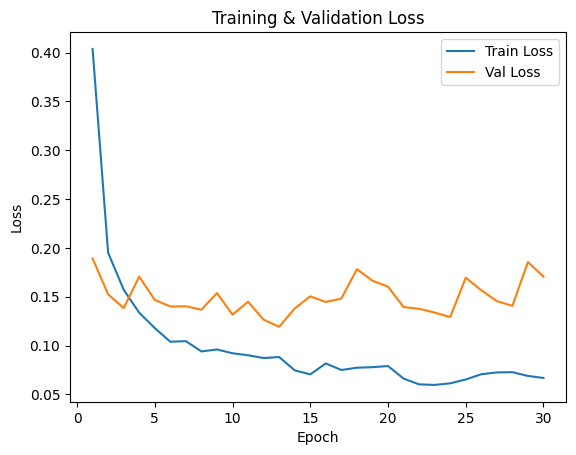

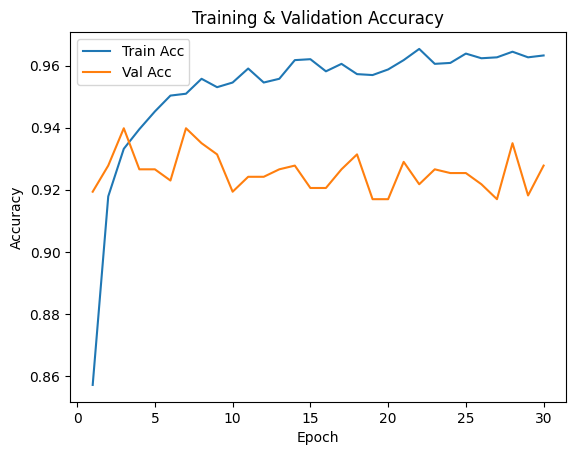

In [7]:
epochs = range(1, num_epochs + 1)

# Loss curve
plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.savefig(OUTPUT_DIR / "loss_curve.png")
plt.show()

# Accuracy curve
plt.figure()
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.savefig(OUTPUT_DIR / "accuracy_curve.png")
plt.show()



Final Test Accuracy: 0.8445

--- Classification Metrics (Macro Avg) ---
Precision: 0.8574
Recall:    0.8338
F1-score:  0.8364

--- Detailed Classification Report ---
                      precision    recall  f1-score   support

     Chorionic_villi       0.95      0.99      0.97       390
     Decidual_tissue       0.71      0.68      0.69       349
          Hemorrhage       0.78      0.97      0.86       421
Trophoblastic_tissue       0.99      0.70      0.82       351

            accuracy                           0.84      1511
           macro avg       0.86      0.83      0.84      1511
        weighted avg       0.86      0.84      0.84      1511



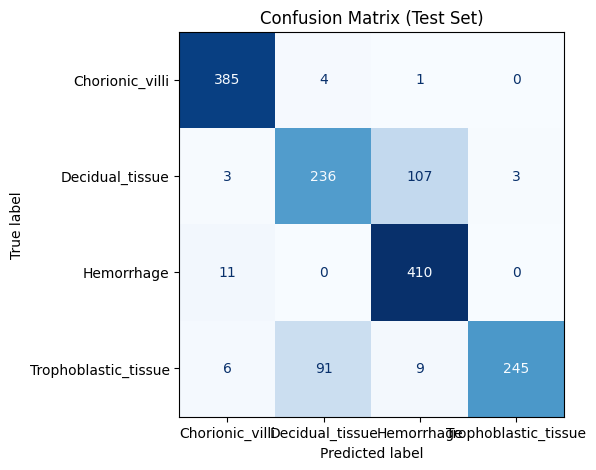

In [9]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

# --------------------------
# Load best model
# --------------------------
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

all_labels = []
all_preds = []
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().tolist())
        all_preds.extend(preds.cpu().tolist())

        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

# --------------------------
# Accuracy
# --------------------------
test_acc = test_correct / test_total if test_total > 0 else 0.0
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

# --------------------------
# Precision, Recall, F1
# --------------------------
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("\n--- Classification Metrics (Macro Avg) ---")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# 전체 클래스별 상세 보고서
print("\n--- Detailed Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

# --------------------------
# Confusion Matrix
# --------------------------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names,
)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (Test Set)")
plt.savefig(OUTPUT_DIR / "confusion_matrix.png")
plt.show()
